# Sentinel-2 cropland mapping

Following the paper by [Belgiu & Csillik (2018)] (see also [Hao et al. 2018](https://peerj.com/articles/5431/?utm_source=TrendMD&utm_campaign=PeerJ_TrendMD_0&utm_medium=TrendMD))(https://www.sciencedirect.com/science/article/pii/S0034425717304686) we can train a CNN for the segmentation of the croplands. As an input we can use [Sentinel-2 MSI](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) multispectral data, and as an output crop types data classified by experts from the European Land Use and Coverage Area Frame Survey ([LUCAS](https://ec.europa.eu/eurostat/statistics-explained/index.php/LUCAS_-_Land_use_and_land_cover_survey)) and  CropScape – Cropland Data Layer ([CDL](https://nassgeodata.gmu.edu/CropScape/)), respectively.

Datasets in Google Earth Engine:

- [Sentinel-2 MSI: MultiSpectral Instrument, Level-1C](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2)
- [USDA NASS Cropland Data Layers](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL)
- [Canada AAFC Annual Crop Inventory](https://developers.google.com/earth-engine/datasets/catalog/AAFC_ACI) 
***

## Configure the Environment

We begin by importing a number of useful libraries

In [1]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image
from functools import reduce
import h5py
import os

Initialize the Earth Engine client.

In [2]:
ee.Initialize()

## GeoTIFF to Google Cloud Storage

In [3]:
from ee_toCloudStorage import ee_image

In [6]:
# Central position of (AOIs)
#points = [[-120.7224, 37.3872], [-112.6799, 42.9816], [-89.7649, 35.8764], 
#          [-96.0181, 41.2412], [-115.473, 46.861], [-103.9803, 47.9713], 
#          [-96.9217, 32.8958], [-82.986, 40.019], [-90.347, 38.668], [-110.6947, 37.4568]]
points = [[-120.7224, 37.3872], [-112.6799, 42.9816]]
# Start and stop of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')
# Scale in meters
scale = 10
# Buffer
buffer = 5000#40000

**Export `.tif` files to Google Cloud Storage**

In [ ]:
for n, point in enumerate(points):
    print('Exporting AOI number:', n)
    sentinel = ee_image(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, file_name='sentinel_AOI_'+'{:02d}'.format(n) , collection = 'Sentinel2')
    sentinel.export_toCloudStorage()
    
    cropland = ee_image(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, file_name='cropland_AOI_'+'{:02d}'.format(n) , collection = 'CroplandDataLayers')
    cropland.export_toCloudStorage()

In [9]:
for n, point in enumerate(points):
    print('Exporting AOI number:', n)
    sentinel = ee_image(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, file_name='sentinel_AOI_test'+'{:02d}'.format(n), dataset_name = 'data_x_'+'{:02d}', collection = 'Sentinel2')
    sentinel.export_toCloudStorage()
    
    cropland = ee_image(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, file_name='cropland_AOI_test'+'{:02d}'.format(n), dataset_name = 'data_y_'+'{:02d}', collection = 'CroplandDataLayers')
    cropland.export_toCloudStorage()

Exporting AOI number: 0
Exporting AOI number: 1


**Read `.tif` files from Google Cloud Storage**

In [11]:
for n, point in enumerate(points):
    print('Exporting AOI number:', n)
    sentinel = ee_image(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, file_name='sentinel_AOI_test'+'{:02d}'.format(n), dataset_name = 'data_x_'+'{:02d}'.format(n), collection = 'Sentinel2')
    sentinel.read_fromCloudStorage()
    
    cropland = ee_image(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, file_name='cropland_AOI_test'+'{:02d}'.format(n), dataset_name = 'data_y_'+'{:02d}'.format(n), collection = 'CroplandDataLayers')
    cropland.read_fromCloudStorage()

Exporting AOI number: 0
Exporting AOI number: 1


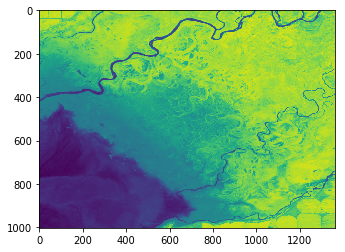

In [13]:
with h5py.File('data_x_01.hdf5', 'r') as f:
    data = f["data_x_01"]
    
    plt.imshow(data[:,:,5])

In [ ]:
with h5py.File('data_y.hdf5', 'a') as f:
    data = f["data_y"]
    
    data[:] = data[:]/data[:].max()

## Preprocess class labels

Each class in encoded as a value in the range between 0 to 254. For training a Neural Network in Keras we have to convert the 1-dimensional class arrays to N classes-dimensional matrices. To simplify the problem here we regroup all the classes into 4 categories, namely, land, water, urban, and cropland areas.

In [ ]:
from preprocess_data import categorical_data

In [ ]:
def replace_values(array, class_labels, new_label):
    array_new = np.copy(array)
    for i in range(len(class_labels)):
        array_new[np.where(array == class_labels[i])] = new_label
        
    return array_new

def categorical_data(data):
    # Area of Interest (AoI)
    point = [-120.7224, 37.3872]
    geom = ee.Geometry.Point(point).buffer(1000)
    # Start and stop of time series
    startDate = ee.Date('2016')
    stopDate  = ee.Date('2017')
    # Read the ImageCollection
    dataset = ee.ImageCollection('USDA/NASS/CDL')\
        .filterBounds(geom)\
        .filterDate(startDate,stopDate)
    # Get the cropland class values and names
    cropland_info = pd.DataFrame({'cropland_class_values':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_values'),
                              'cropland_class_palette':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_palette'),
                              'cropland_class_names':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_names')
                             })
    

    # New classes
    land = ['Shrubland', 'Barren', 'Grassland/Pasture', 'Deciduous Forest', 'Evergreen Forest', 'Mixed Forest', 'Wetlands', 'Woody Wetlands', 'Herbaceous Wetlands']
    water = ['Water', 'Open Water', 'Aquaculture']
    urban = ['Developed', 'Developed/Open Space', 'Developed/High Intensity', 'Developed/Low Intensity', 'Developed/Med Intensity']

    class_labels_0 = np.array(cropland_info[cropland_info['cropland_class_names'].isin(land)]['cropland_class_values'])
    class_labels_1 = np.array(cropland_info[cropland_info['cropland_class_names'].isin(water)]['cropland_class_values'])
    class_labels_2 = np.array(cropland_info[cropland_info['cropland_class_names'].isin(urban)]['cropland_class_values'])
    class_labels_3 = np.array(cropland_info[(~cropland_info['cropland_class_names'].isin(land)) & 
                                        (~cropland_info['cropland_class_names'].isin(water)) & 
                                        (~cropland_info['cropland_class_names'].isin(urban))]['cropland_class_values'])

    # We replace the class labels
    new_data = np.copy(data[:,:,0])
    new_data = replace_values(new_data, class_labels_3, 3.)
    new_data = replace_values(new_data, class_labels_2, 2.)
    new_data = replace_values(new_data, class_labels_1, 1.)
    new_data = replace_values(new_data, class_labels_0, 0.)

    # Convert 1-dimensional class arrays to 4-dimensional class matrices
    from keras.utils import np_utils
    new_data = np_utils.to_categorical(new_data, 4)
    
    return new_data

In [ ]:
with h5py.File('data_y.hdf5', 'a') as f:
    data = f["data_y"]
    
    data[:] = categorical_data(data[:])

In [ ]:
data_y = categorical_data(data_y)

## Normalize input data
Normalize the input channels to the range [0,1]

In [ ]:
from preprocess_data import normalize_data

In [ ]:
data_x = normalize_data(data_x)

## Resize the images

In [ ]:
from preprocess_data import resize_patches

In [ ]:
data_x, data_y = resize_patches(data_x, data_y, patch_size=128)

## Randomize the datasets

In [ ]:
from preprocess_data import randomize_datasets

In [ ]:
data_x, data_y = randomize_datasets(data_x, data_y)

## Training and validation sets

In [ ]:
from preprocess_data import train_validation_split

In [ ]:
x_train, x_validation, y_train, y_validation = train_validation_split(data_x, data_y)

## Save datasets

In [ ]:
from preprocess_data import write_data

In [ ]:
# Save samples
write_data("../SegNet/Samples/x_train.h5", 'x_train', x_train)
write_data("../SegNet/Samples/y_train.h5", 'y_train', y_train)
write_data("../SegNet/Samples/x_validation.h5", 'x_validation', x_validation)
write_data("../SegNet/Samples/y_validation.h5", 'y_validation', y_validation)

## Train the Network 

To train SegNet from the command line type:

```python
python train_SegNet.py -i Samples/ -o Network/SegNet -e 20 -a start
```

The parameters are:

```
-i = Samples/model 
    Path of the input files.
-o = network/model 
    Path of the output file that will contain the network weights.
-e = 20
    Number of epochs to use during training.
-a = {start,continue}
     `start`: start a new calculation
     `continue`: continue a previous calculation
```

## Predict

**Read data**

In [ ]:
# Central position of (AOIs)
point = [-112.0087, 43.4952]
# Start and stop of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')
# Scale in meters
scale = 10
# Buffer
buffer = 10000

In [ ]:
sentinel = ee_datasets(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
cropland = ee_datasets(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, collection = 'CroplandDataLayers')
data_x = sentinel.read_datasets()
data_y = cropland.read_datasets()

**Preprocess class labels**

In [ ]:
data_y.shape

In [ ]:
data_y_new = np.zeros((1, 2005, 2745, 1), dtype=np.float32)
data_y_new[0,:,:,:] = data_y

In [ ]:
data_y = categorical_data(data_y_new)

**Normalize input data**

In [ ]:
data_x_new = np.zeros((1, 2005, 2745, 6), dtype=np.float32)
data_x_new[0,:,:,:] = data_x

In [ ]:
data_x = normalize_data(data_x_new)

**Save datasets**

In [ ]:
# Save samples
write_data("../SegNet/Samples/data_x.h5", 'data_x', data_x)

**Prediction**

To use SegNet from the command line type:

```python
python SegNet.py -i Samples/data_x.h5 -o Predictions/output.h5 -c 4
```

The parameters are:

```
-i = Samples/file 
    Path of the input file.
-o = Predictions/file
    Path of the output file.
-c = 4
    Number of classes.
```

**Read dataset**

In [ ]:
f = h5py.File("../SegNet/Predictions/output.h5", 'r')
output = f.get("out")

In [ ]:
f = h5py.File("../SegNet/Predictions/output_0.h5", 'r')
output_0 = f.get("out")

## Display results

In [ ]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

Sentinel 2 composite

In [ ]:
display_channels(data_x[0,:,:,:], data_x.shape[3], titles=['Blue', 'Green', 'Red', 'NIR', 'NDVI', 'NDWI'])

Ground truth land cover classification

In [ ]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles=['Land', 'Water', 'Urban', 'Cropland'])

Network output

In [ ]:
display_channels(output[0,:,:,:], output.shape[3], titles=['Land', 'Water', 'Urbar', 'Cropland'])

We binarize the output taking the highest pixel value

In [ ]:
from preprocess_data import max_pixels

In [ ]:
# Binarize the output
def max_pixels(x):
    x_new = x*0
    max_val = np.amax(x, axis=2)
    size = x.shape
    for i in range(size[-1]):
        ima = x[:,:,i]*0
        ima[np.where(x[:,:,i] == max_val)] = 1
        x_new[:,:,i]= ima

    return x_new

In [ ]:
output_max = max_pixels(output[0,:,:,:])

In [ ]:
display_channels(output_max, output_max.shape[2], titles=['Land', 'Water', 'Urbar', 'Cropland'])

## From GEE to Numpy
https://mygeoblog.com/2017/10/06/from-gee-to-numpy-to-geotiff/

In [ ]:
from ee_np_array import ee_np_array

In [ ]:
# Central position of (AOIs)
point = [-122.938, 46.151]
# Start and stop of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')
# Scale in meters
scale = 10
# Buffer
buffer = 5000

In [ ]:
sentinel = ee_np_array(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
cropland = ee_np_array(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, collection = 'CroplandDataLayers')
dataset_x = sentinel.read_datasets()
dataset_y = cropland.read_datasets()

## Download datasets
We download and append datasets from different Areas of Interest (AOIs)

In [ ]:
from ee_datasets import ee_datasets

In [ ]:
sentinel = ee_datasets(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
dataset_x = sentinel.read_datasets()

In [ ]:
dataset_x.shape

In [ ]:
# Central position of (AOIs)
#points = [[-120.7224, 37.3872], [-112.6799, 42.9816], [-89.7649, 35.8764], 
#          [-96.0181, 41.2412], [-115.473, 46.861], [-103.9803, 47.9713], [-96.9217, 32.8958]]

# lat < -115
points = [[-123.488, 47.712], [-122.191, 47.608], [-122.96, 46.802], [-121.752, 46.847], [-121.95, 46.531], 
          [-122.938, 46.151], [-122.015, 45.892], [-122.653, 45.539], [-122.894, 45.231], [-123.136, 44.452],
         [-123.312, 43.279], [-122.872, 42.361], [-121.95, 42.442], [-122.411, 41.577], [-121.796, 41.28],
         [-122.169, 40.131], [-121.928, 39.354], [-121.686, 38.876], [-121.4, 38.619], [-121.356, 38.137],
         [-120.983, 37.651], [-120.543, 37.022], [-119.269, 37.163], [-118.676, 37.093],[-119.686, 36.06],
         [-117.973, 34], [-120.09, 47.862], [-118.991, 47.729], [-119.782, 47.06], [-117.277, 47.313], 
         [-117.299, 46.789], [-117.607, 46.533], [-115.937, 47.179], [-119.606, 45.91], [-119.804, 45.572],
         [-119.189, 45.403], [-118.442, 44.876], [-117.277, 45.14], [-116.293, 43.609], [-117.019, 43.974],
         [-118.93, 43.529], [-118.754, 43.306], [-117.941, 42.404], [-120.424, 41.948], [-118.776, 41.125],
         [-118.557, 40.041], [-119.128, 38.973], [-118.71, 38.682], [-117.178, 37.294], [-116.299, 33.736],
         [-115.859, 33.223], [-115.508, 32.983], [-115.134, 36.149], [-116.255, 48.159], [-121.914, 37.286]]

# Start and stop of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')
# Scale in meters
scale = 10
# Buffer
buffer = 11000

In [ ]:
for n, point in enumerate(points):
    print('Downloading AOI number:', n)
    sentinel = ee_datasets(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
    cropland = ee_datasets(point = point, buffer = buffer, startDate = startDate, stopDate = stopDate, scale = scale, collection = 'CroplandDataLayers')
    dataset_x = sentinel.read_datasets()
    dataset_y = cropland.read_datasets()
    
    if n == 0:
        dim_x = dataset_x.shape
        dim_x = list(dim_x)
        dim_x = [1] + dim_x
        dim_x[1] = 2200; dim_x[2] = 2200
        
        dim_y = dataset_y.shape
        dim_y = list(dim_y)
        dim_y = [1] + dim_y
        dim_y[1] = 2200; dim_y[2] = 2200
        
        data_x = np.zeros(dim_x, dtype=np.float32)
        data_y = np.zeros(dim_y, dtype=np.float32)
        
        data_x[0,:] = dataset_x[:dim_x[1],:dim_x[2],:dim_x[3]]
        data_y[0,:] = dataset_y[:dim_y[1],:dim_y[2],:dim_y[3]]
    else:
        data_x2 = np.zeros(dim_x, dtype=np.float32)
        data_y2 = np.zeros(dim_y, dtype=np.float32)
        
        data_x2[0,:] = dataset_x[:dim_x[1],:dim_x[2],:dim_x[3]]
        data_y2[0,:] = dataset_y[:dim_y[1],:dim_y[2],:dim_y[3]]
        
        data_x = np.append(data_x, data_x2, axis=0)
        data_y = np.append(data_y, data_y2, axis=0)

## Test

**Download `.tif` files to a local directory**

In [ ]:
from google.cloud import storage

def download_fromCloudStorage(project_name, bucket_name, file_path_cloud, file_path_local):
    # Initialise a client
    storage_client = storage.Client(project_name)
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket(bucket_name)
    # Create a blob object from the filepath
    blob = bucket.blob(file_path_cloud)
    # Download the file to a destination
    blob.download_to_filename(file_path_local)

In [ ]:
project_name = 'skydipper'
bucket_name = "skydipper_materials"
path_cloud = "gee_data/"
path_local = "./Data/"
for n, point in enumerate(points):
    print('Downloading AOI number:', n)
    file_name = 'sentinel_AOI_'+'{:02d}'.format(n)+'.tif'
    download_fromCloudStorage(project_name, bucket_name, file_path_cloud = path_cloud + file_name, file_path_local = path_local + file_name)
    
    file_name = 'cropland_AOI_'+'{:02d}'.format(n)+'.tif'
    download_fromCloudStorage(project_name, bucket_name, file_path_cloud = path_cloud + file_name, file_path_local = path_local + file_name)

In [ ]:
import subprocess

bucket_name = "skydipper_materials"
path_cloud = "gee_data/"
path_local = "./Data/test/"
file_name = 'sentinel_AOI_00.tif'

subprocess.call(f"gsutil -m cp gs://{bucket_name}/{path_cloud}{file_name} {path_local}{file_name}", shell=True)

In [ ]:
# Initialise a client
storage_client = storage.Client()
# Create a bucket object for our bucket
bucket = storage_client.get_bucket("skydipper_materials")
# Create a blob object from the filepath
blob = bucket.blob("gee_data/sentinel_AOI_00.tif")
# Download the file to a destination
blob.download_to_filename('./Data/test/sentinel_AOI_00.tif')

**Read datasets from `.tif`**

In [ ]:
import rasterio
import os, urllib

def load_tif_bands(file_path):
    data = np.array([]) 

    image = rasterio.open(file_path)
    nBands = image.count
    szy = image.height
    szx = image.width
    
    dataset = np.zeros((szy,szx,0), dtype=np.float32)
    data = np.zeros((szy,szx,0), dtype=np.float32)
    
    for n in range(nBands):
        data = np.zeros((szy,szx,1), dtype=np.float32)
        data[:,:,0] = image.read(1+n)
        
        dataset = np.append(dataset, data, axis=2)
    
    return dataset

In [ ]:
path_local = "./Data/"
nAOI = len(points)
for n, point in enumerate(points):
    print('Reading AOI number:', n)
    
    file_name = 'sentinel_AOI_'+'{:02d}'.format(n)+'.tif'
    dataset_x = load_tif_bands(path_local+file_name)
    
    file_name = 'cropland_AOI_'+'{:02d}'.format(n)+'.tif'
    dataset_y = load_tif_bands(path_local+file_name)
    
    if n == 0:
        dim_x = dataset_x.shape
        dim_x = list(dim_x)
        dim_x = [1] + dim_x
        dim_x[1] = dim_x[1]-4
        dim_x[2] = dim_x[1]
        
        dim_y = dataset_y.shape
        dim_y = list(dim_y)
        dim_y = [1] + dim_y
        dim_y[1] = dim_y[1]-4
        dim_y[2] = dim_y[1]
        
        with f = h5py.File('data_x.hdf5', 'w') as f:
            data_x = f.create_dataset("data_x", dim_x, chunks=True, dtype=np.float32)
        
        with f = h5py.File('data_y.hdf5', 'w') as f:
            data_y = f.create_dataset("data_y", dim_y, chunks=True, dtype=np.float32)
        
        data_x[0,:] = dataset_x[:dim_x[1],:dim_x[2],:dim_x[3]]
        data_y[0,:] = dataset_y[:dim_y[1],:dim_y[2],:dim_y[3]]
    else:
        with f = h5py.File('data_x2.hdf5', 'w') as f:
            data_x2 = f.create_dataset("data_x2", dim_y, chunks=True, dtype=np.float32)
        
        with f = h5py.File('data_y2.hdf5', 'w') as f:
            data_y2 = f.create_dataset("data_y2", dim_y, chunks=True, dtype=np.float32)
        
        data_x2[0,:] = dataset_x[:dim_x[1],:dim_x[2],:dim_x[3]]
        data_y2[0,:] = dataset_y[:dim_y[1],:dim_y[2],:dim_y[3]]
        
        
        data_x = np.append(data_x, data_x2, axis=0)
        data_y = np.append(data_y, data_y2, axis=0)
        
        os.remove('data_x2.hdf5') 
        os.remove('data_y2.hdf5') 